In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance, ImageOps
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # Changed back to 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),  # Changed back to 128 channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),  # Changed back to 128 channels
            ResidualBlock(128),
            ResidualBlock(128)   # Added back the third residual block
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),  # Changed to match checkpoint
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),   # Changed to match checkpoint
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),    # Changed to match checkpoint
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

In [10]:
class EnhancedDRDataset(Dataset):
    def __init__(self, df, base_image_dir, label_mapping, generator_model, device, img_size=(224, 224)):
        self.df = df
        self.base_image_dir = base_image_dir
        self.label_mapping = label_mapping
        self.img_size = img_size
        self.generator = generator_model
        self.device = device
        
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
    def enhance_image(self, image):
        # Convert to PIL Image if it's not already
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
            
        # Apply GAN enhancement
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            enhanced = self.generator(img_tensor)
        
        # Convert back to image
        enhanced = enhanced.squeeze(0).cpu()
        enhanced = enhanced * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        enhanced = enhanced.clamp(0, 1)
        enhanced = transforms.ToPILImage()(enhanced)
        
        # Adjust enhancement parameters
        enhanced = ImageEnhance.Brightness(enhanced).enhance(1.1)  # Reduced enhancement
        enhanced = ImageEnhance.Contrast(enhanced).enhance(1.6)     # Reduced enhancement
        enhanced = ImageEnhance.Sharpness(enhanced).enhance(1.7)    # Reduced enhancement

        return enhanced
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row['diagnosis']
        
        # Find the image in the appropriate directory
        for label_name, label_num in self.label_mapping.items():
            img_dir = os.path.join(self.base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                # Load and enhance the image
                image = Image.open(img_path).convert('RGB')
                enhanced_image = self.enhance_image(image)
                
                # Convert to numpy array and normalize
                enhanced_array = np.array(enhanced_image)
                enhanced_array = enhanced_array / 255.0
                
                return enhanced_array, label
                
        raise FileNotFoundError(f"Image not found for id_code: {row['id_code']}")

In [11]:
def preprocess_data_with_gan(df, base_image_dir, label_mapping, generator_model, device, img_size=(224, 224)):
    images = []
    labels = []
    
    # Create an instance of EnhancedDRDataset for image enhancement
    dataset = EnhancedDRDataset(df, base_image_dir, label_mapping, generator_model, device)
    
    for index, row in df.iterrows():
        for label_name, label_num in label_mapping.items():
            img_dir = os.path.join(base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                # Get enhanced image using GAN
                image, _ = dataset[index]
                
                # Convert to cv2 format and resize
                image = (image * 255).astype(np.uint8)
                image = cv2.resize(image, img_size)
                
                images.append(image)
                labels.append(label_num)

    images = np.array(images)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=5)

    return images, labels

In [12]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [13]:
# Load your data
data_path = 'FGADR/train.csv'
df = pd.read_csv(data_path)
base_image_dir = 'FGADR'

# Define label mapping
label_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4
}

c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Original class distribution: Counter({np.int64(0): 1454, np.int64(2): 786, np.int64(1): 302, np.int64(4): 230, np.int64(3): 157})
Balanced class distribution: Counter({np.int64(0): 1454, np.int64(3): 1454, np.int64(2): 1454, np.int64(4): 1454, np.int64(1): 1454})


c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 409s 2s/step - accuracy: 0.3533 - loss: 9.5488 - val_accuracy: 0.6794 - val_loss: 0.9249
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.5266 - loss: 1.1282 - val_accuracy: 0.6930 - val_loss: 0.8698
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.5972 - loss: 1.0113 - val_accuracy: 0.7053 - val_loss: 0.8384
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.7264 - loss: 0.7203 - val_accuracy: 0.6971 - val_loss: 0.8940
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8464 - loss: 0.4591 - val_accuracy: 0.7162 - val_loss: 1.0518
Epoch 6/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.8991 - loss: 0.2949 - val_accuracy: 0.7067 - val_loss: 1.1934
Epoch 7/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.9270 - loss: 0.2177 - val_accuracy: 0.6985 - val_loss: 1.3117
Epoch 8/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9390 - loss: 0.1805 - val_accu

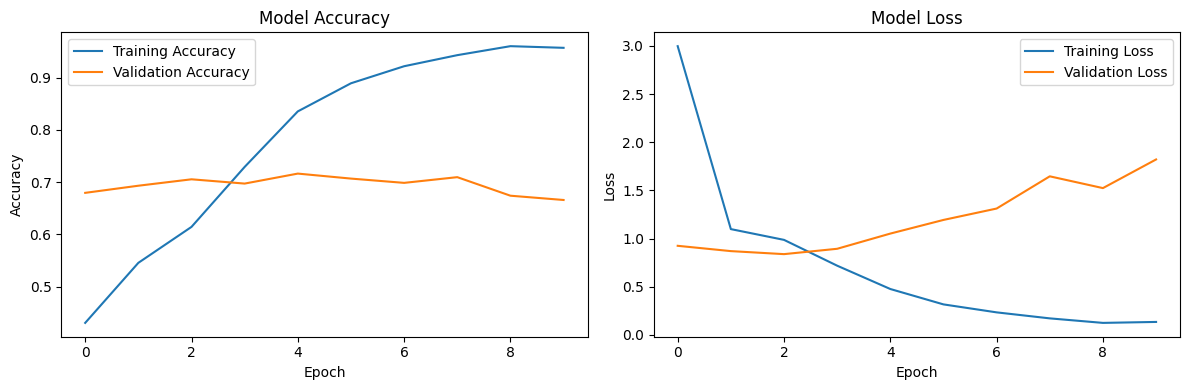

In [14]:
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras._tf_keras.keras.layers import (
    Conv2D, 
    MaxPooling2D, 
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization
)
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam
from collections import Counter
from imblearn.over_sampling import SMOTE
from keras._tf_keras.keras.callbacks import ModelCheckpoint

# [6] Model Training with SMOTE
# Set up device and load generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
checkpoint = torch.load('enhanced_gan_models.pth', map_location=device)
generator.load_state_dict(checkpoint['model_state_dict'])
generator.eval()

# Preprocess data
images, labels = preprocess_data_with_gan(
    df=df,
    base_image_dir=base_image_dir,
    label_mapping=label_mapping,
    generator_model=generator,
    device=device
)

# Split data
X_train_tuned, X_val_tuned, y_train_tuned, y_val_tuned = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Apply SMOTE for balanced classes
X_train_reshaped = X_train_tuned.reshape(X_train_tuned.shape[0], -1)
y_train_classes = np.argmax(y_train_tuned, axis=1)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reshaped, y_train_classes)

# Reshape back to image format
X_train_balanced = X_train_resampled.reshape(-1, 224, 224, 3)
y_train_balanced = to_categorical(y_train_resampled, num_classes=5)

# Print class distribution
print("Original class distribution:", Counter(y_train_classes))
print("Balanced class distribution:", Counter(y_train_resampled))

# Create and train the balanced model
cnn_model_balanced = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile and train
cnn_model_balanced.compile(optimizer=Adam(learning_rate=0.001), 
                         loss='categorical_crossentropy', 
                         metrics=['accuracy'])


# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='best_model_checkpoint.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

history_balanced = cnn_model_balanced.fit(
    X_train_balanced, 
    y_train_balanced,
    epochs=10,
    validation_data=(X_val_tuned, y_val_tuned)
)

# Plot training history
plot_training_history(history_balanced)

In [27]:
cnn_model_balanced.save('DR_model_final.h5')


In [15]:
from keras._tf_keras.keras.callbacks import ModelCheckpoint

# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='CNN_model.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 445ms/step


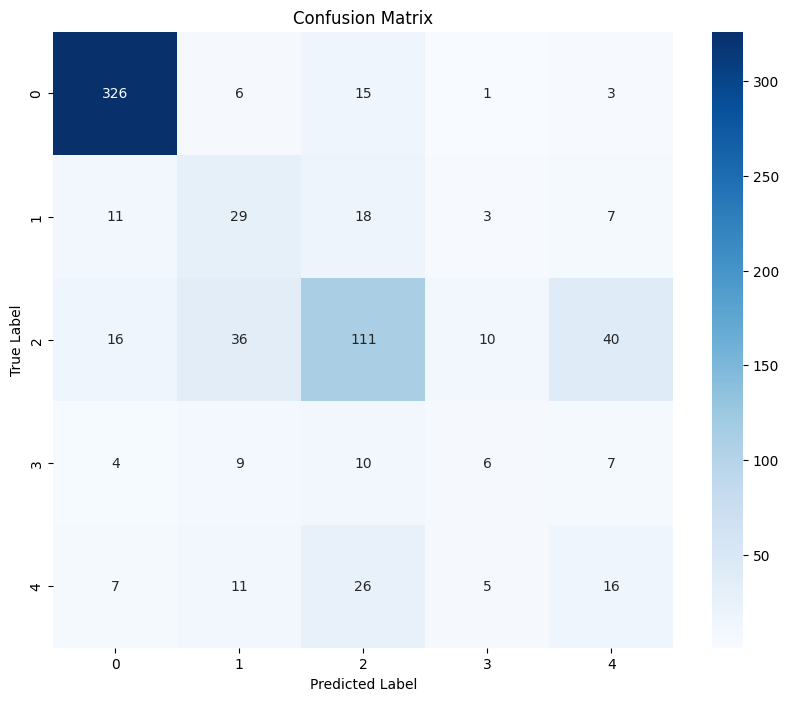

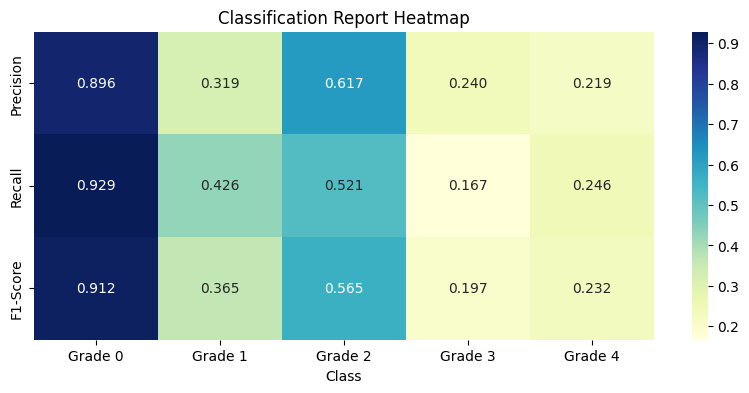

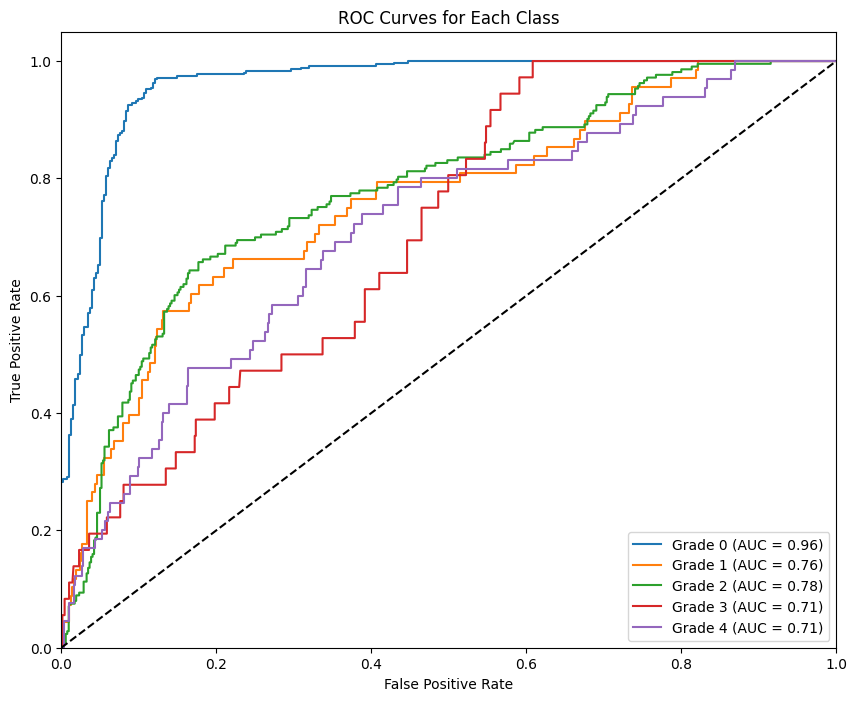

In [16]:
# ... existing code ...
# After training, get predictions
y_pred = cnn_model_balanced.predict(X_val_tuned)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_tuned, axis=1)

# Create confusion matrix plot
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot classification report as heatmap
def plot_classification_report(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    # Extract metrics for each class
    report_data = []
    for k, v in report.items():
        if k not in ('accuracy', 'macro avg', 'weighted avg'):
            report_data.append([k, v['precision'], v['recall'], v['f1-score']])
    
    df_report = pd.DataFrame(report_data, columns=['Class', 'Precision', 'Recall', 'F1-Score'])
    df_report_transposed = df_report.set_index('Class').T
    
    plt.figure(figsize=(10, 4))
    sns.heatmap(df_report_transposed, annot=True, cmap='YlGnBu', fmt='.3f')
    plt.title('Classification Report Heatmap')
    plt.show()

# Plot per-class metrics
class_names = ['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3', 'Grade 4']
plot_classification_report(y_true_classes, y_pred_classes, class_names)

# Plot ROC curves
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10, 8))

for i in range(5):
    fpr, tpr, _ = roc_curve(y_val_tuned[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Grade {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 476ms/step


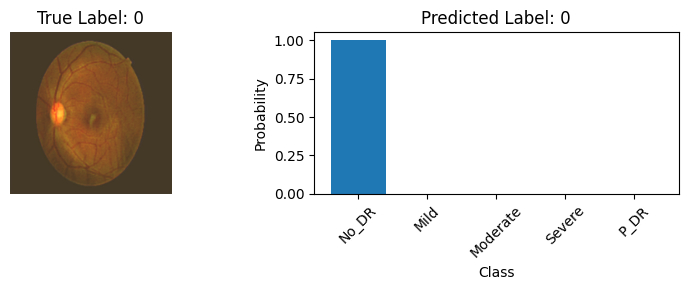

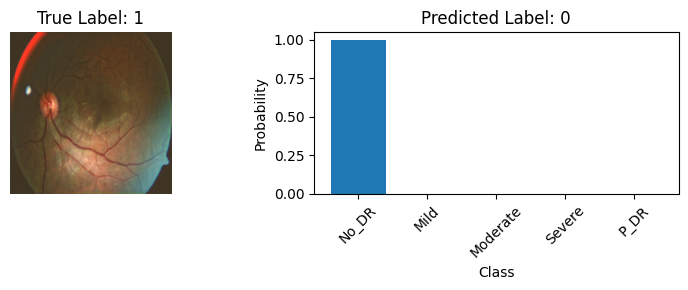

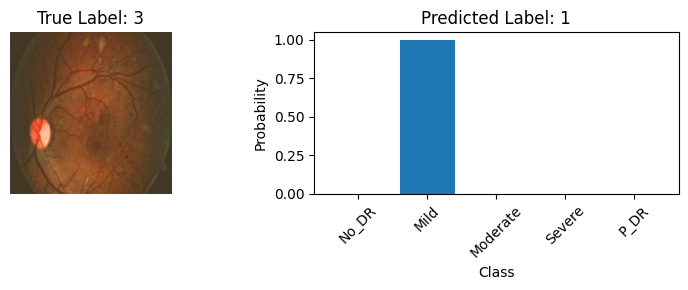

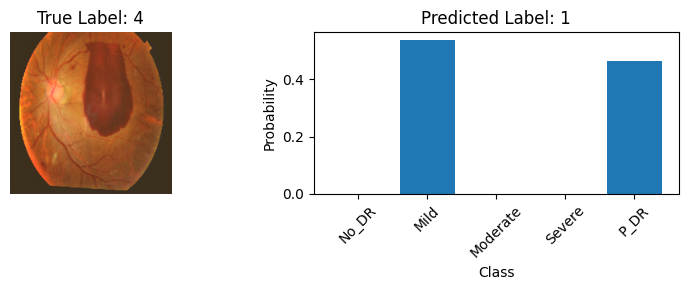

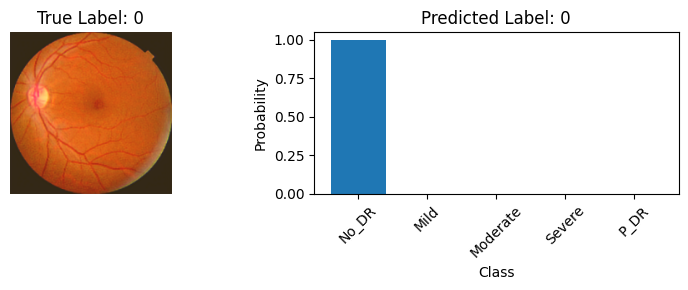

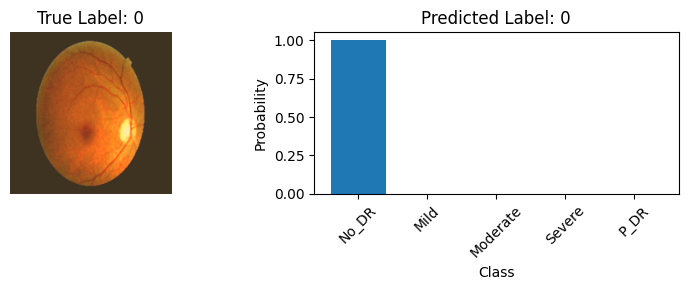

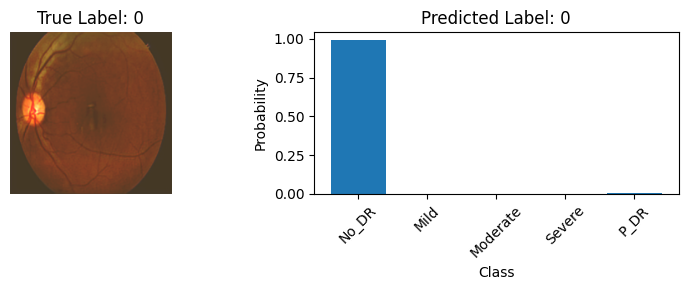

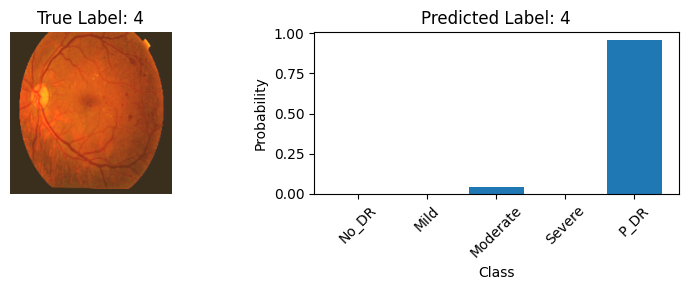

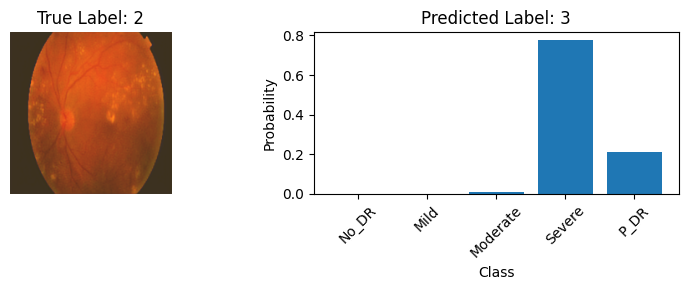

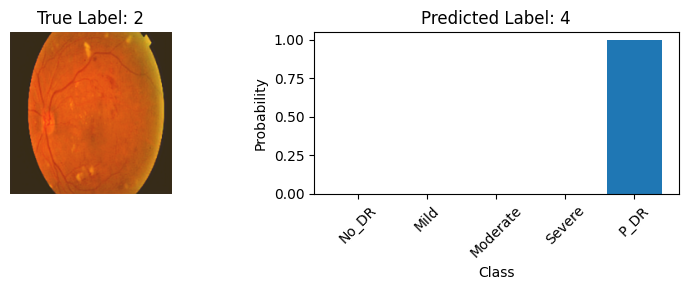

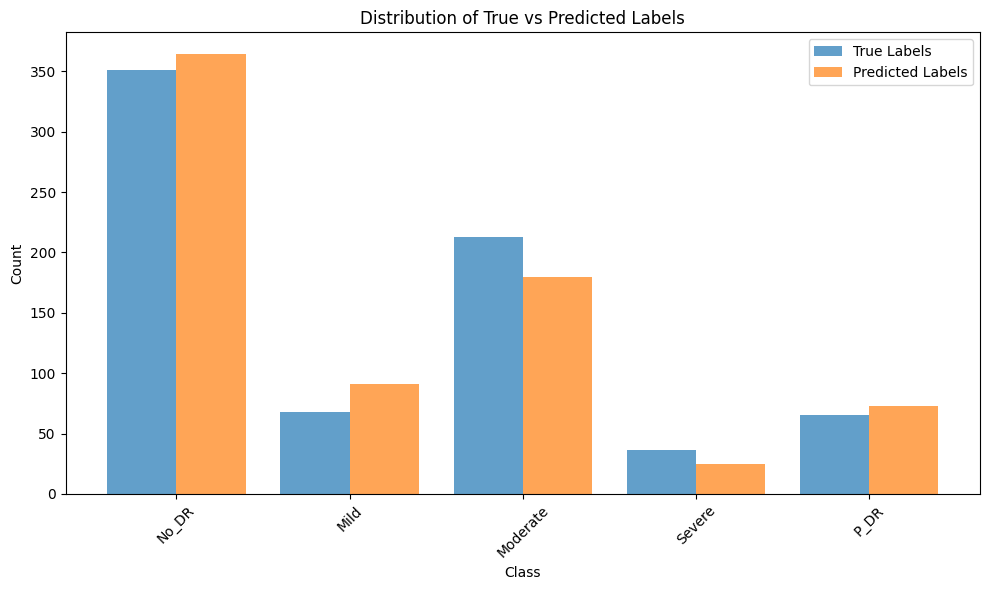

In [17]:
# Get predictions for validation data
predictions = cnn_model_balanced.predict(X_val_tuned)
predicted_classes = np.argmax(predictions, axis=1)

# Visualize test images and their predictions
num_samples_to_visualize = 10
class_names = ['No_DR', 'Mild', 'Moderate', 'Severe', 'P_DR']

for i in range(num_samples_to_visualize):
    plt.figure(figsize=(8, 3))
    
    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_val_tuned[i])
    plt.title(f"True Label: {np.argmax(y_val_tuned[i])}")
    plt.axis('off')
    
    # Plot prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(5), predictions[i])
    plt.xticks(range(5), class_names, rotation=45)
    plt.title(f"Predicted Label: {predicted_classes[i]}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    
    plt.tight_layout()
    plt.show()

# Additionally, let's create a summary plot of prediction distribution
plt.figure(figsize=(10, 6))
true_labels = np.argmax(y_val_tuned, axis=1)
pred_labels = predicted_classes

# Plot distribution of predictions vs true labels
plt.hist([true_labels, pred_labels], label=['True Labels', 'Predicted Labels'], 
         bins=np.arange(6)-0.5, alpha=0.7)
plt.xticks(range(5), class_names, rotation=45)
plt.title('Distribution of True vs Predicted Labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

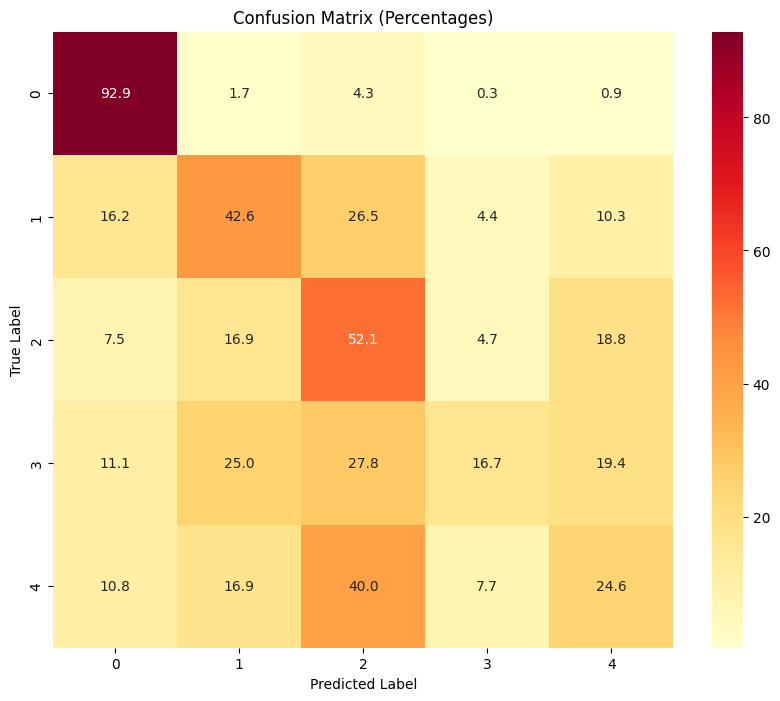

In [18]:
# 4. Confusion Matrix with Percentages
plt.figure(figsize=(10, 8))
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='YlOrRd')
plt.title('Confusion Matrix (Percentages)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

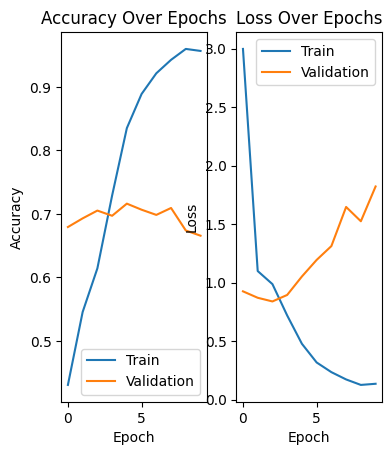

In [20]:
plt.subplot(1, 3, 1)
plt.plot(history_balanced.history['accuracy'], label='Train')
plt.plot(history_balanced.history['val_accuracy'], label='Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history_balanced.history['loss'], label='Train')
plt.plot(history_balanced.history['val_loss'], label='Validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

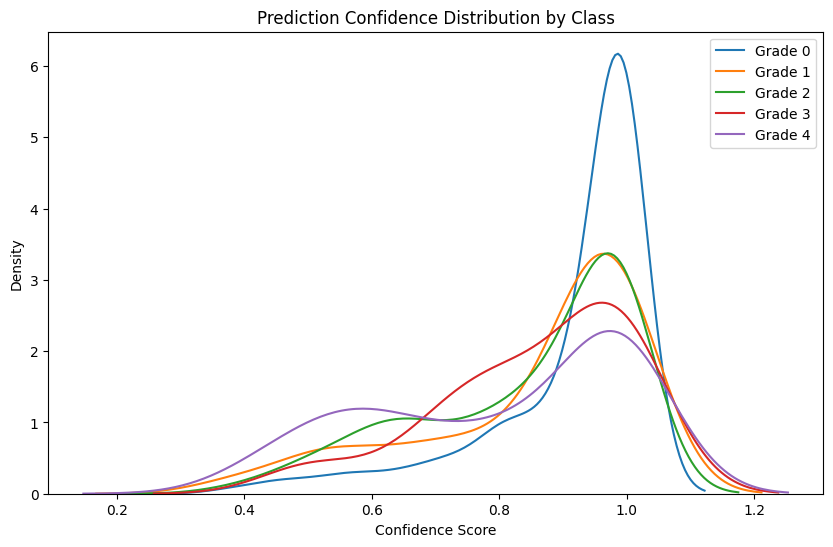

In [21]:
plt.figure(figsize=(10, 6))
confidence_scores = np.max(y_pred, axis=1)
for i in range(5):
    class_confidence = confidence_scores[y_pred_classes == i]
    if len(class_confidence) > 0:
        sns.kdeplot(class_confidence, label=f'Grade {i}')

plt.title('Prediction Confidence Distribution by Class')
plt.xlabel('Confidence Score')
plt.ylabel('Density')
plt.legend()
plt.show()

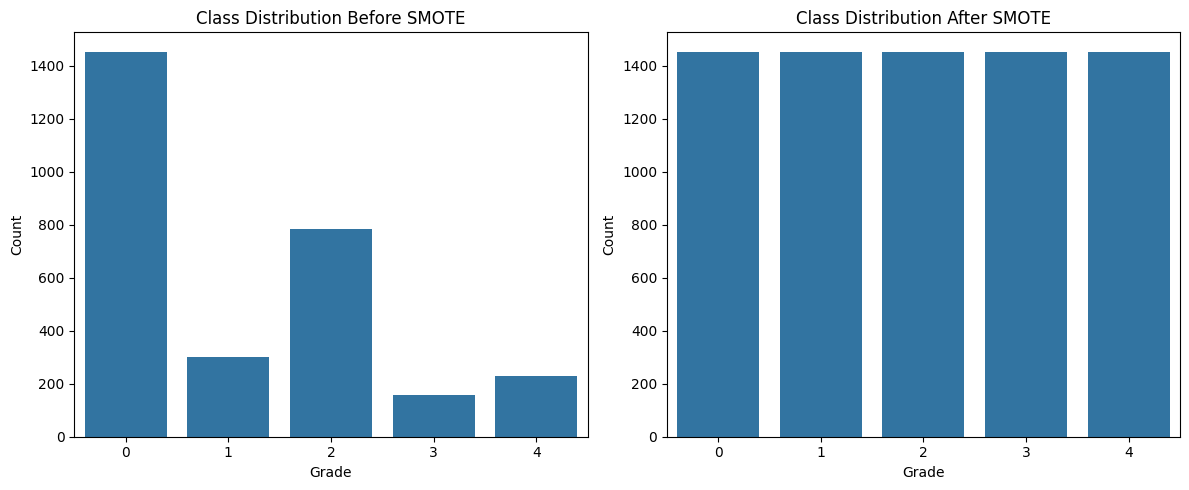

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=list(Counter(y_train_classes).keys()), 
            y=list(Counter(y_train_classes).values()))
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Grade')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=list(Counter(y_train_resampled).keys()), 
            y=list(Counter(y_train_resampled).values()))
plt.title('Class Distribution After SMOTE')
plt.xlabel('Grade')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

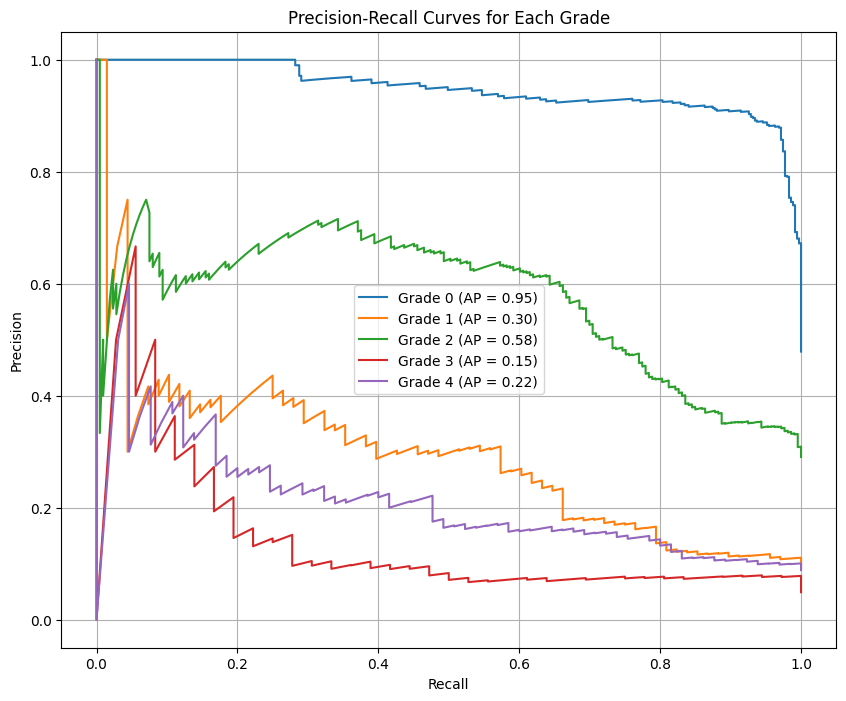

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Per-Class Precision-Recall Curves
plt.figure(figsize=(10, 8))
for i in range(5):
    precision, recall, _ = precision_recall_curve(y_val_tuned[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_val_tuned[:, i], y_pred[:, i])
    plt.plot(recall, precision, label=f'Grade {i} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Grade')
plt.legend(loc='best')
plt.grid(True)
plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 469ms/step

Accuracy by class:
Grade 0:
Correct Predictions: 326/351
Accuracy: 92.88%

Grade 1:
Correct Predictions: 47/68
Accuracy: 69.12%

Grade 2:
Correct Predictions: 197/213
Accuracy: 92.49%

Grade 3:
Correct Predictions: 23/36
Accuracy: 63.89%

Grade 4:
Correct Predictions: 21/65
Accuracy: 32.31%



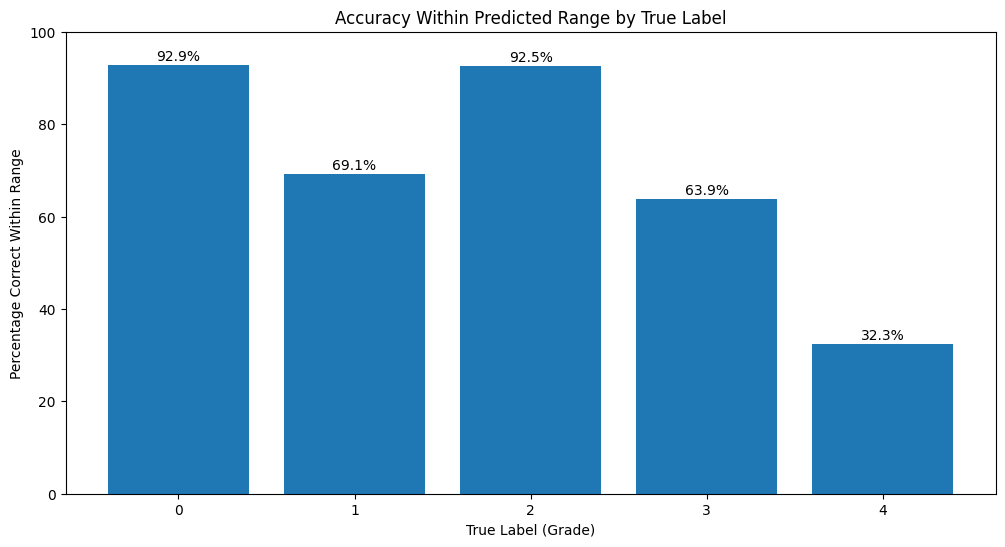

In [25]:
def get_range_predictions(y_pred, confidence_threshold=0.3):
    """
    Convert model predictions to ranges based on specified rules:
    Grade 0: Predict exactly 0
    Grade 1: Range 1 to 2
    Grade 2: Range 1 to 3
    Grade 3: Range 2 to 4
    Grade 4: Range 2 to 4
    """
    ranges = []
    
    for pred_probs in y_pred:
        pred_class = np.argmax(pred_probs)
        
        # Apply specific range rules
        if pred_class == 0:
            ranges.append("0")  # Exact prediction for grade 0
        elif pred_class == 1:
            ranges.append("1 to 2")  # Range for grade 1
        elif pred_class == 2:
            ranges.append("1 to 3")  # Range for grade 2
        elif pred_class == 3:
            ranges.append("2 to 4")
        elif pred_class == 4:  # For grades 3 and 4
            ranges.append("2 to 4")
            
    return ranges

# Example usage:
y_pred = cnn_model_balanced.predict(X_val_tuned)
range_predictions = get_range_predictions(y_pred)

# Calculate accuracy within ranges
correct_within_range = 0
true_labels = np.argmax(y_val_tuned, axis=1)

for true_label, pred_range in zip(true_labels, range_predictions):
    if pred_range == "0":
        correct = (true_label == 0)
    else:
        min_pred, max_pred = map(int, pred_range.split(' to '))
        correct = (min_pred <= true_label <= max_pred)
    
    if correct:
        correct_within_range += 1

# Calculate and display results by class
results = {0:[], 1:[], 2:[], 3:[], 4:[]}
for true_label, pred_range in zip(true_labels, range_predictions):
    if pred_range == "0":
        correct = (true_label == 0)
    else:
        min_pred, max_pred = map(int, pred_range.split(' to '))
        correct = (min_pred <= true_label <= max_pred)
    results[true_label].append(correct)

# Print results
print("\nAccuracy by class:")
for grade in range(5):
    class_results = results[grade]
    if class_results:
        accuracy = (sum(class_results) / len(class_results)) * 100
        total = len(class_results)
        correct = sum(class_results)
        print(f"Grade {grade}:")
        print(f"Correct Predictions: {correct}/{total}")
        print(f"Accuracy: {accuracy:.2f}%\n")

# Visualization
plt.figure(figsize=(12, 6))
accuracies = []
for grade in range(5):
    if results[grade]:
        accuracy = (sum(results[grade]) / len(results[grade])) * 100
        accuracies.append(accuracy)
    else:
        accuracies.append(0)

plt.bar(range(5), accuracies)
plt.title('Accuracy Within Predicted Range by True Label')
plt.xlabel('True Label (Grade)')
plt.ylabel('Percentage Correct Within Range')
plt.ylim(0, 100)

for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')

plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 468ms/step

Class 4 Accuracy: 24.62%

Class 4 Confusion Matrix:
[[611  57]
 [ 49  16]]


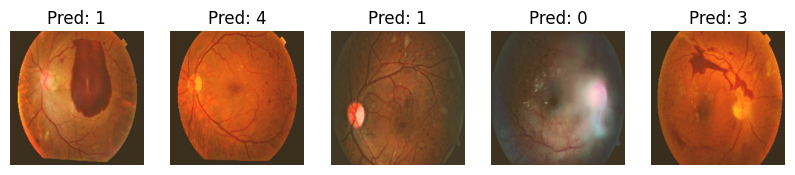

In [26]:
# Evaluate performance specifically for class 4
y_pred = cnn_model_balanced.predict(X_val_tuned)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val_tuned, axis=1)

# Class 4 specific metrics
class_4_mask = (y_true_classes == 4)
class_4_accuracy = np.mean(y_pred_classes[class_4_mask] == y_true_classes[class_4_mask])
print(f"\nClass 4 Accuracy: {class_4_accuracy * 100:.2f}%")

# Confusion matrix for class 4
class_4_confusion = confusion_matrix(y_true_classes == 4, y_pred_classes == 4)
print("\nClass 4 Confusion Matrix:")
print(class_4_confusion)

# Plot class 4 predictions
plt.figure(figsize=(10, 5))
class_4_samples = X_val_tuned[class_4_mask][:5]
class_4_preds = y_pred[class_4_mask][:5]

for i, (img, pred) in enumerate(zip(class_4_samples, class_4_preds)):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'Pred: {np.argmax(pred)}')
    plt.axis('off')
plt.show()